In [1]:
import contextlib
import datasets
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet, words
from nltk.stem import WordNetLemmatizer
import mmh3
import numpy as np
from bitarray import bitarray
import contextlib
import numpy as np
import time
import string
import nltk
import json

import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

lemmatize = lambda word: nlp(str(word))[0].lemma_

nltk.download('stopwords')
nltk.download('wordnet')
en_stopwords = set(stopwords.words('english'))

data = datasets.load_dataset("wikipedia", "20220301.en")
# data = datasets.load_dataset("bookcorpus/bookcorpus")
# data = []
# for i in range (1, 1731):
#     with contextlib.suppress(FileNotFoundError):
#         with open(f'data/fairy_tales/{i}.txt', 'rb') as f:
#             data.append(f.read())

/Users/Yourui/Documents/bloom-filters/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yourui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Yourui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = data['train']

In [3]:
def tokenize(sentence):
    tokenized = nlp(sentence.translate(str.maketrans('', '', string.punctuation)))
    return [token.lemma_ for token in tokenized if token.lemma_ not in en_stopwords and wordnet.synsets(token.lemma_)]

In [4]:
tokenize(sent_tokenize(data[0]['text'])[0])

['anarchism',
 'political',
 'philosophy',
 'movement',
 'sceptical',
 'authority',
 'reject',
 'involuntary',
 'coercive',
 'form',
 'hierarchy']

In [5]:
def hash_token(token, bits):
    representation = np.zeros(32)
    
    for i in range(3):
        digest = mmh3.hash(token, i) % bits
        representation[digest] = 1
    return representation

In [6]:
with open('data/wikipedia_20000_tf-idf.json', 'r') as f:
    tf_idfs = json.load(f)

In [7]:
def get_bloom_filters(word, n_occurrences=10000, deltas=None, bits=32):
    if deltas is None:
        deltas = [-4, -3, -2, -1, 1, 2, 3, 4]
    word = lemmatize(word) # using the old lemmatizer, shouldn't necessarily be an issue right now

    return_data = []
    occurrences = 0

    for i, row in enumerate(data):
        # try:
        #     sentences = sent_tokenize(row['text'].decode('cp1252').lower())
        # except UnicodeDecodeError:
        #     sentences = sent_tokenize(row['text'].decode('utf8').lower())

        sentences = sent_tokenize(row['text'].lower())

        for sentence in sentences:
            if word in sentence:
                tokenized = tokenize(sentence)

                indices = [i for i, x in enumerate(tokenized) if x == word]
                for index in indices:
                    representation = np.zeros(32)

                    for delta in deltas:
                        with contextlib.suppress(IndexError):
                            adjacent_word = tokenized[index + delta]
                            try:
                                tf_idf = tf_idfs[word][adjacent_word]['tf-idf']
                            except KeyError:
                                tf_idf = 0
                            representation += np.array(list(hash_token(adjacent_word, bits))) * tf_idf

                    return_data.append(list(representation))
                    occurrences += 1

                    if n_occurrences and occurrences >= n_occurrences:
                        return return_data

        if i % 10 == 0:
            print(f'"{word}", {i}th row processed, {occurrences}/{n_occurrences} occurrences')

    return return_data

In [8]:
# keep only the most frequently occurring words next to the target word (ex: 1000+ occurrences) + aggregate those words + collect data
    # Table 1: Most frequent words
    # Table 2: Most frequent words with count vectors
# test discarding bits with high variance values

In [9]:
def store_encoding(word, fname, args):
    frequencies = get_bloom_filters(word, **args)
    
    with open(fname, 'r') as f:
        encodings = json.load(f)
    encodings[word] = frequencies
    with open(fname, 'w') as f:
        json.dump(encodings, f, indent=4)

In [10]:
l = ["man","woman","king","queen"]

for value in l:
    store_encoding(value, 'data/wikipedia_20000_vectors.json', {'n_occurrences':20000, 'deltas': [-4, -3, -2, -1, 1, 2, 3, 4]})

"man", 0th row processed, 0/20000 occurrences
"man", 10th row processed, 33/20000 occurrences
"man", 20th row processed, 67/20000 occurrences
"man", 30th row processed, 81/20000 occurrences
"man", 40th row processed, 91/20000 occurrences
"man", 50th row processed, 91/20000 occurrences
"man", 60th row processed, 115/20000 occurrences
"man", 70th row processed, 122/20000 occurrences
"man", 80th row processed, 138/20000 occurrences
"man", 90th row processed, 145/20000 occurrences
"man", 100th row processed, 154/20000 occurrences
"man", 110th row processed, 165/20000 occurrences
"man", 120th row processed, 171/20000 occurrences
"man", 130th row processed, 194/20000 occurrences
"man", 140th row processed, 222/20000 occurrences
"man", 150th row processed, 243/20000 occurrences
"man", 160th row processed, 260/20000 occurrences
"man", 170th row processed, 265/20000 occurrences
"man", 180th row processed, 267/20000 occurrences
"man", 190th row processed, 278/20000 occurrences
"man", 200th row p

In [11]:
with open('data/wikipedia_20000_vectors.json', 'r') as f:
    data = json.load(f)

# removes newlines in lists for readability
import re
def repl_func(match: re.Match):
    return " ".join(match.group().split())
json_str = json.dumps(data, indent=4)
json_str = re.sub(r"(?<=\[)[^\[\]]+(?=])", repl_func, json_str)

with open('data/wikipedia_20000_vectors.json', 'w') as f:
    f.write(json_str)

In [12]:
data

{'man': [[0.0,
   0.0,
   0.0,
   0.0,
   0.0006483622259264669,
   0.0,
   0.00018490532508399056,
   0.0,
   8.260056618933552e-05,
   0.0002549562043976217,
   0.0,
   0.0,
   0.0004389827645912993,
   7.3722717065482e-05,
   0.0,
   0.0003563821984019638,
   7.3722717065482e-05,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0004942339100757671,
   0.0,
   0.0003585771658060815,
   0.0003585771658060815,
   0.0,
   0.00011929946012793608,
   0.0,
   6.560586495605449e-05,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0004301049154674458,
   0.0,
   6.560586495605449e-05,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0003563821984019638,
   7.3722717065482e-05,
   0.0,
   0.0003563821984019638,
   7.3722717065482e-05,
   7.221572280716957e-05,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0003585771658060815,
   0.0,
   0.0003585771658060815,
   0.00043079288861325106,
   0.0,
   0.0,
   0.0,
   0.00013782158776322404,
   0.0],
  [0.0,
   2.0653987871978322e-05,
   0.0,
   2.065

In [13]:
labels = np.concatenate([np.array([word for _ in data[word]]) for word in data.keys()])
lookup, clabels = np.unique(labels, return_inverse=True)
vectors = np.concatenate([np.array(list(word_data)) for word_data in data.values()])

import random
c = list(zip(clabels, vectors))
random.shuffle(c)
clabels, vectors = zip(*c)

lookup

array(['king', 'man', 'queen', 'woman'], dtype='<U5')

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
features_pca = pca.fit_transform(vectors)

/var/folders/h1/88vswkjs65x3v7m1ytlwgpy40000gp/T/ipykernel_46558/3568445535.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 4)


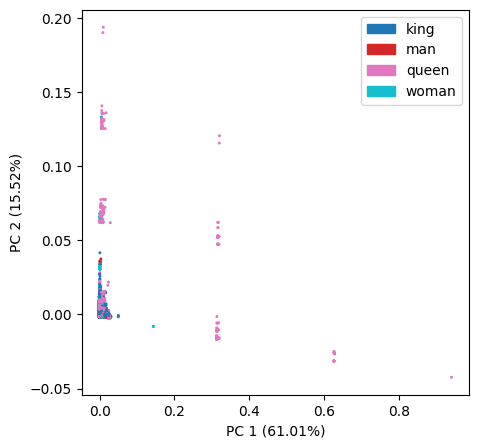

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

cmap = plt.cm.get_cmap('tab10', 4)

plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.scatter(features_pca[:,0], features_pca[:,1], c=clabels, cmap='tab10', s=5, marker='.')

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

plt.legend([mpatches.Patch(color=cmap(b)) for b in range(4)], lookup)

plt.savefig('pca.png', dpi=300)
plt.show()